## Importing Packages & Datasets

### Importing Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import optuna
from sklearn.feature_selection import VarianceThreshold,RFE, mutual_info_classif, RFECV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, make_scorer, precision_recall_curve
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier


### Importing Dataset

In [31]:
# CHANGE PATH
fold_1 = pd.read_csv('C:/Users/matth/Documents/Y3S1/CS3244/proj_data/smote_train_data/fold_1.csv')
fold_2 = pd.read_csv('C:/Users/matth/Documents/Y3S1/CS3244/proj_data/smote_train_data/fold_2.csv')
fold_3 = pd.read_csv('C:/Users/matth/Documents/Y3S1/CS3244/proj_data/smote_train_data/fold_3.csv')
fold_4 = pd.read_csv('C:/Users/matth/Documents/Y3S1/CS3244/proj_data/smote_train_data/fold_4.csv')
fold_5 = pd.read_csv('C:/Users/matth/Documents/Y3S1/CS3244/proj_data/smote_train_data/fold_5.csv')
smote_fold_1 = pd.read_csv('C:/Users/matth/Documents/Y3S1/CS3244/proj_data/smote_train_data/smote_fold_1.csv')
smote_fold_2 = pd.read_csv('C:/Users/matth/Documents/Y3S1/CS3244/proj_data/smote_train_data/smote_fold_2.csv')
smote_fold_3 = pd.read_csv('C:/Users/matth/Documents/Y3S1/CS3244/proj_data/smote_train_data/smote_fold_3.csv')
smote_fold_4 = pd.read_csv('C:/Users/matth/Documents/Y3S1/CS3244/proj_data/smote_train_data/smote_fold_4.csv')
smote_fold_5 = pd.read_csv('C:/Users/matth/Documents/Y3S1/CS3244/proj_data/smote_train_data/smote_fold_5.csv')
test_set = pd.read_csv('C:/Users/matth/Documents/Y3S1/CS3244/proj_data/transformed_data/test_set.csv')
folds = [fold_1, fold_2, fold_3, fold_4, fold_5]
smotes = [smote_fold_1, smote_fold_2, smote_fold_3, smote_fold_4, smote_fold_5]

## Logistic Regression Model

We will proceed with this flow:

1. Logistic Regression Model Development
Train a logistic regression model on the preprocessed dataset, adjusting hyperparameters and exploring regularization techniques (e.g., L1 or L2) to prevent overfitting.

2. Model Evaluation
Evaluate the model's performance using utility fraud-specific metrics such as precision, recall, F1-score, AUC-ROC, and confusion matrix analysis.
Assess the balance between false positives and false negatives to minimize both missed fraud and unnecessary alerts.

### Preparing Data

In [3]:
training_data = pd.concat([smote_fold_1, smote_fold_2, smote_fold_3, smote_fold_4])
X_train = training_data.drop(columns='fraud_status')
y_train = training_data['fraud_status']
X_val = fold_5.drop(columns='fraud_status')
y_val = fold_5['fraud_status']

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_val)
print(classification_report(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
print("Accuracy:", accuracy_score(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.02      0.03     20478
         1.0       0.06      1.00      0.11      1200

    accuracy                           0.07     21678
   macro avg       0.52      0.51      0.07     21678
weighted avg       0.94      0.07      0.03     21678

Confusion Matrix:
 [[  313 20165]
 [    2  1198]]
Accuracy: 0.06970200202970754


Accuracy is very poor from this training data. Some columns might not have been useful for predicting fraud status hence we have chosen to remove `month_number`,  `region  _101` to `region_399`, `district_62` to `district_69` and `client_catg_11` to `client_catg_51` as after excluding, the model's performance improved significantly. Columns like `creation` date were also removed as they are not directly relevant to predicting fraud and could introduce noise to the model.

In [4]:
training_data = pd.concat([smote_fold_1, smote_fold_2, smote_fold_3, smote_fold_4])
columns_drop = ['fraud_status', 'creation_year', 'creation_month', 'creation_day', 'months_number_min', 
                'months_number_max', 'months_number_median', 'region_101','region_103', 
                'region_104', 'region_105', 'region_106', 'region_107',
                   'region_199', 'region_206', 'region_301', 'region_302', 'region_303',
                   'region_304', 'region_305', 'region_306', 'region_307', 'region_308',
                   'region_309', 'region_310', 'region_311', 'region_312', 'region_313',
                   'region_371', 'region_372', 'region_379', 'region_399',
                   'district_62', 'district_63', 'district_69', 'client_catg_11', 'client_catg_12',
                   'client_catg_51']
X_train = training_data.drop(columns=columns_drop)
y_train = training_data['fraud_status']
X_val = fold_5.drop(columns=columns_drop)
y_val = fold_5['fraud_status']

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)

### Training Base Model

In [5]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [6]:
y_pred = log_reg.predict(X_val)

In [7]:
print(classification_report(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
print("Accuracy:", accuracy_score(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.56      0.71     20478
         1.0       0.10      0.88      0.19      1200

    accuracy                           0.58     21678
   macro avg       0.55      0.72      0.45     21678
weighted avg       0.94      0.58      0.68     21678

Confusion Matrix:
 [[11438  9040]
 [  143  1057]]
Accuracy: 0.5763908109604207


## RFE

In [8]:
scores = []

max_features = X_train.shape[1]
for n in range(1, max_features + 1): 
    rfe = RFE(estimator= LogisticRegression(max_iter=500), n_features_to_select=n)
    X_train_rfe = rfe.fit_transform(X_train, y_train)
    score = np.mean(cross_val_score(LogisticRegression(max_iter=500), X_train_rfe, y_train, cv=5))
    scores.append(score)

best_n_features = np.argmax(scores) + 1
print(f"Best number of features to select: {best_n_features}")

Best number of features to select: 40


In [9]:
rfe = RFE(estimator=LogisticRegression(max_iter=500), n_features_to_select=40)
X_train_rfe = rfe.fit_transform(X_train, y_train)

X_val_rfe = X_val.iloc[:, rfe.support_] if hasattr(X_val, 'iloc') else X_val[:, rfe.support_]

log_reg = LogisticRegression(max_iter=500)
log_reg.fit(X_train_rfe, y_train)

y_pred = log_reg.predict(X_val_rfe)

In [10]:
print(classification_report(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
print("Accuracy:", accuracy_score(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.56      0.71     20478
         1.0       0.10      0.88      0.19      1200

    accuracy                           0.58     21678
   macro avg       0.55      0.72      0.45     21678
weighted avg       0.94      0.58      0.68     21678

Confusion Matrix:
 [[11409  9069]
 [  141  1059]]
Accuracy: 0.5751453086078051


Some of the features eliminated by RFE may have been important for prediction hence a slight decrease in accuracy.

## PCA

In [11]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train)

### Plotting Cumulative Variance

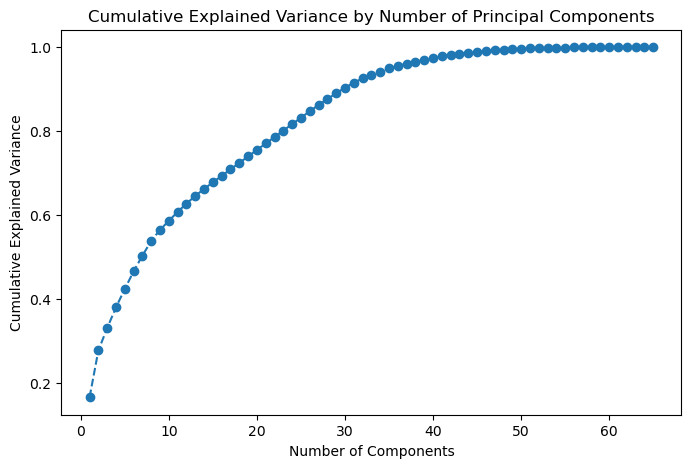

Number of components explaining 95% variance: 36


In [12]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Number of Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()
n_components = np.argmax(pca.explained_variance_ratio_.cumsum() >= 0.95) + 1
print(f"Number of components explaining 95% variance: {n_components}")

In [13]:
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.fit_transform(X_val)

In [14]:
log_reg = LogisticRegression()
log_reg.fit(X_train_pca, y_train)

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [15]:
y_pred = log_reg.predict(X_val_pca)

In [16]:
print(classification_report(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
print("Accuracy:", accuracy_score(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.58      0.72     20478
         1.0       0.08      0.63      0.14      1200

    accuracy                           0.58     21678
   macro avg       0.52      0.60      0.43     21678
weighted avg       0.91      0.58      0.69     21678

Confusion Matrix:
 [[11801  8677]
 [  448   752]]
Accuracy: 0.579066334532706


By using PCA, we can see there is a slight increase in the accuracy from 0.575 to 0.579.

## Hyperparameter Tuning

### Preparing Data

In [23]:
X_smoted_1 = smote_fold_1.drop(columns=columns_drop)
y_smoted_1 = smote_fold_1['fraud_status']
X_smoted_2 = smote_fold_2.drop(columns=columns_drop)
y_smoted_2 = smote_fold_2['fraud_status']
X_smoted_3 = smote_fold_3.drop(columns=columns_drop)
y_smoted_3 = smote_fold_3['fraud_status']
X_smoted_4 = smote_fold_4.drop(columns=columns_drop)
y_smoted_4 = smote_fold_4['fraud_status']
X_smoted_5 = smote_fold_5.drop(columns=columns_drop)
y_smoted_5 = smote_fold_5['fraud_status']
smoted_folds = [(X_smoted_1, y_smoted_1), (X_smoted_2, y_smoted_2), (X_smoted_3, y_smoted_3), (X_smoted_4, y_smoted_4), (X_smoted_5, y_smoted_5)]

X_fold_1 = fold_1.drop(columns=columns_drop)
y_fold_1 = fold_1['fraud_status']
X_fold_2 = fold_2.drop(columns=columns_drop)
y_fold_2 = fold_2['fraud_status']
X_fold_3 = fold_3.drop(columns=columns_drop)
y_fold_3 = fold_3['fraud_status']
X_fold_4 = fold_4.drop(columns=columns_drop)
y_fold_4 = fold_4['fraud_status']
X_fold_5 = fold_5.drop(columns=columns_drop)
y_fold_5 = fold_5['fraud_status']
folds = [(X_fold_1, y_fold_1), (X_fold_2, y_fold_2), (X_fold_3, y_fold_3), (X_fold_4, y_fold_4), (X_fold_5, y_fold_5)]


### Sampling & Scaling Data

In [24]:
# Fit the scaler on the entire training data (folds[0][0])
scaler.fit(folds[0][0])

# Modify the sample_fold function to scale the input data
def sample_fold(X, y, sample_fraction=0.1):
    sample_size = int(len(X) * sample_fraction)
    sample_indices = np.random.choice(len(X), sample_size, replace=False)
    X_sample = scaler.transform(X.iloc[sample_indices])  # Scale X_sample
    return pd.DataFrame(X_sample, columns=X.columns), y.iloc[sample_indices]

# Take 50% samples of each original and SMOTEd fold (and apply scaling)
sampled_folds = [sample_fold(X, y) for X, y in folds]
sampled_smoted_folds = [sample_fold(X, y) for X, y in smoted_folds]


In [25]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

def objective(trial):
    C = trial.suggest_float('C', 0.01, 100, log=True)  # Regularization strength
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    solver = 'liblinear' if penalty == 'l1' else 'lbfgs'
  
    # Initialize the LogRegression with the current hyperparameters
    log_reg = LogisticRegression(
        C=C,
        penalty=penalty,
        solver=solver,
        max_iter=1000,
        random_state=42
    )

    # List to store F1 scores for each fold
    f1_scores = []

    # Perform 5-fold cross-validation
    for i in range(5):
        # Get the non-SMOTEd validation set (sampled)
        X_val1, y_val1 = sampled_folds[i]

        # Combine the other 4 SMOTEd folds to create the training set (sampled)
        X_train1 = pd.concat([sampled_smoted_folds[j][0] for j in range(5) if j != i], axis=0)
        y_train1 = pd.concat([sampled_smoted_folds[j][1] for j in range(5) if j != i], axis=0)
        X_train1 = pca.fit_transform(X_train1)
        # Train the MLP model on the sampled SMOTEd training set
        log_reg.fit(X_train1, y_train1)

        # Predict on the non-SMOTEd validation set
        X_val1 = pca.fit_transform(X_val1)
        y_pred1 = log_reg.predict(X_val1)

        # Calculate F1 score and store it
        f1 = f1_score(y_val1, y_pred1, average='weighted')
        f1_scores.append(f1)

    # Return the mean F1 score across all folds
    return np.mean(f1_scores)

# Use Optuna to find the best hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30, show_progress_bar=True, n_jobs=-1)


[I 2024-12-01 11:06:08,896] A new study created in memory with name: no-name-d428f655-56d3-4a30-84c0-7b6ff71cbab6


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2024-12-01 11:06:20,596] Trial 11 finished with value: 0.6297477539909065 and parameters: {'C': 0.02502996107713526, 'penalty': 'l1'}. Best is trial 11 with value: 0.6297477539909065.
[I 2024-12-01 11:06:20,909] Trial 1 finished with value: 0.6303989118796984 and parameters: {'C': 0.029789950739379886, 'penalty': 'l1'}. Best is trial 1 with value: 0.6303989118796984.
[I 2024-12-01 11:06:21,009] Trial 2 finished with value: 0.6310487559815259 and parameters: {'C': 0.0330179345620157, 'penalty': 'l1'}. Best is trial 2 with value: 0.6310487559815259.
[I 2024-12-01 11:06:23,426] Trial 7 finished with value: 0.6347791418298563 and parameters: {'C': 0.34218232925137454, 'penalty': 'l1'}. Best is trial 7 with value: 0.6347791418298563.
[I 2024-12-01 11:06:23,767] Trial 5 finished with value: 0.635710356819211 and parameters: {'C': 0.04634167482187092, 'penalty': 'l2'}. Best is trial 5 with value: 0.635710356819211.
[I 2024-12-01 11:06:26,599] Trial 6 finished with value: 0.6296345675804293

### Best Parameters

In [26]:
# Get the best parameters from Optuna
best_trial = study.best_trial
best_params = study.best_params
print("Best Hyperparameters:", best_params)
print("Best cross-validation F1-score:", study.best_value)

# Extracting best parameters
best_C = best_params['C']
best_penalty = best_params['penalty']

Best Hyperparameters: {'C': 0.16864903576823906, 'penalty': 'l2'}
Best cross-validation F1-score: 0.6381163414977737


### Using Best Parameters

In [27]:
best_model = LogisticRegression(C=best_C, penalty=best_penalty, max_iter=500)
best_model.fit(X_train_pca, y_train)
y_pred = best_model.predict(X_val_pca)

## Adjusting Threshold

Best threshold for F1-score: 0.6845115397370422


C:\Users\matth\AppData\Local\Temp\ipykernel_28824\3709321474.py:3: RuntimeWarning: invalid value encountered in divide
  f1_scores = np.where((precision + recall) == 0, 0, 2 * (precision * recall) / (precision + recall))


Text(0.5, 1.0, 'Precision-Recall Curve')

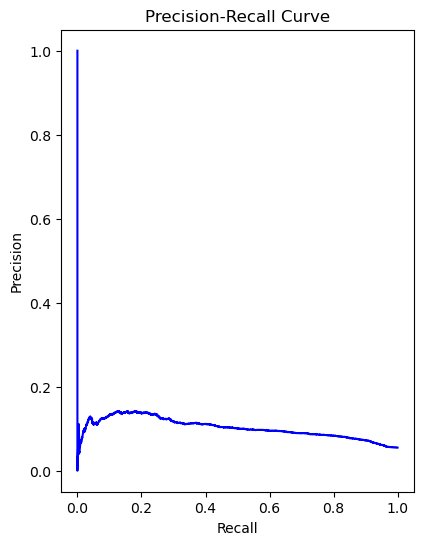

In [28]:
y_prob = best_model.predict_proba(X_val_pca)[:, 1]
precision, recall, threshold = precision_recall_curve(y_val, y_prob)
f1_scores = np.where((precision + recall) == 0, 0, 2 * (precision * recall) / (precision + recall))
best_threshold = threshold[np.argmax(f1_scores)]
print(f"Best threshold for F1-score: {best_threshold}")

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(recall, precision, color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

In [29]:
y_pred_best_threshold = (y_prob >= best_threshold).astype(int)
print(classification_report(y_val, y_pred_best_threshold))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_best_threshold))
print("Accuracy:", accuracy_score(y_val, y_pred_best_threshold))

              precision    recall  f1-score   support

         0.0       0.96      0.81      0.88     20478
         1.0       0.11      0.41      0.17      1200

    accuracy                           0.79     21678
   macro avg       0.54      0.61      0.53     21678
weighted avg       0.91      0.79      0.84     21678

Confusion Matrix:
 [[16532  3946]
 [  707   493]]
Accuracy: 0.7853584278992527


By choosing a threshold based on the distribution of predictions and the cost-benefit trade-off of errors, we can achieve a better balance between true positives and true negatives, thus improving accuracy to 0.785.

## K-Folds Cross Validation

In [32]:
for i in range(len(folds)):
    test_fold = folds[i]
    train_folds = [fold for j, fold in enumerate(smotes) if j != i]
    X_train = pd.concat([fold.drop(columns=columns_drop) for fold in train_folds], axis=0)
    y_train = pd.concat([fold['fraud_status'] for fold in train_folds], axis=0)
    X_val = test_fold.drop(columns=columns_drop)
    y_val = test_fold['fraud_status']

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.fit_transform(X_val)
    X_train_scaled = pca.fit_transform(X_train_scaled)
    X_val_scaled = pca.fit_transform(X_val)
    best_model.fit(X_train_scaled, y_train)
    y_pred = best_model.predict(X_val_scaled)
    y_pred_best_threshold = (y_pred >= best_threshold).astype(int)
    print(f"Classification Report for fold {i + 1}:\n", classification_report(y_val, y_pred_best_threshold))
    print(f"Confusion Matrix for fold {i + 1}:\n", confusion_matrix(y_val, y_pred_best_threshold))
    print(f"Accuracy for fold {i + 1}: {accuracy_score(y_val, y_pred_best_threshold):.4f}")
    print("-" * 50)


Classification Report for fold 1:
               precision    recall  f1-score   support

         0.0       0.96      0.66      0.78     20479
         1.0       0.08      0.53      0.14      1200

    accuracy                           0.65     21679
   macro avg       0.52      0.60      0.46     21679
weighted avg       0.91      0.65      0.75     21679

Confusion Matrix for fold 1:
 [[13536  6943]
 [  565   635]]
Accuracy for fold 1: 0.6537
--------------------------------------------------
Classification Report for fold 2:
               precision    recall  f1-score   support

         0.0       0.93      0.36      0.52     20479
         1.0       0.05      0.56      0.09      1200

    accuracy                           0.37     21679
   macro avg       0.49      0.46      0.31     21679
weighted avg       0.88      0.37      0.50     21679

Confusion Matrix for fold 2:
 [[ 7404 13075]
 [  524   676]]
Accuracy for fold 2: 0.3727
-----------------------------------------------

### Results

High precision for class 0.0 (Non-Fraud), model rarely misclassifies non-fraud cases as fraud. Decent accuracy for most folds except `fold 2` with 0.3. There is still low recall and F1-score for class 1.0 (Fraud) which indicates that this model is failing to detect a significant portion of fraud cases.

## Preparing Test Data & Train Data

In [33]:
columns_drop1 = ['fraud_status', 'creation_year', 'creation_month', 'creation_day', 'months_number_min', 
                'months_number_max', 'months_number_median', 'region_101','region_103', 
                'region_104', 'region_105', 'region_106', 'region_107',
                   'region_199', 'region_206', 'region_301', 'region_302', 'region_303',
                   'region_304', 'region_305', 'region_306', 'region_307', 'region_308',
                   'region_309', 'region_310', 'region_311', 'region_312', 'region_313',
                   'region_371', 'region_372', 'region_379', 'region_399',
                   'district_62', 'district_63', 'district_69', 'client_catg_11', 'client_catg_12',
                   'client_catg_51', 'client_id', 'creation_date']
X_test = test_set.drop(columns=columns_drop1)
y_test = test_set['fraud_status']
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)
X_test_scaled = pca.fit_transform(X_test_scaled)

In [34]:
training_data = pd.concat([smote_fold_1, smote_fold_2, smote_fold_3, smote_fold_4, smote_fold_5])
X_train = training_data.drop(columns=columns_drop)
X_train = pca.fit_transform(X_train)
y_train = training_data['fraud_status']

In [35]:
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test_scaled)
y_pred_best_threshold = (y_pred >= best_threshold).astype(int)
print(classification_report(y_test, y_pred_best_threshold))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best_threshold))
print("Accuracy:", accuracy_score(y_test, y_pred_best_threshold))

              precision    recall  f1-score   support

         0.0       0.96      0.52      0.67     25535
         1.0       0.08      0.65      0.14      1564

    accuracy                           0.52     27099
   macro avg       0.52      0.58      0.40     27099
weighted avg       0.91      0.52      0.64     27099

Confusion Matrix:
 [[13202 12333]
 [  552  1012]]
Accuracy: 0.524521200044282


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Model Evaluation
Model has high precision for class 0.0 (Non-Fraud) and slightly better recall for class 1.0 (Fraud Cases). Precision for class 1.0 is extremely low indicating that the model generates a lot of false positives. The slightly better recall for class 1.0 of 0.65 is decent but the low precision indicates that the model is trading off correctness for identifying fraud cases. The accuracy of 0.52 suggest that the model is slightly better random guessing hence not a good model to use for fraud detection.